In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def make_arrow_graph(
    ax, data, size=4, display="length", shape="right", max_arrow_width=0.03, ec=None,
    arrow_sep=0.02, alpha=0.5, normalize_data=False, labelcolor=None, **kwargs
):
    """
    Makes an arrow plot.
    
    Parameters
    ----------
    ax
        The axes where the graph is drawn.
    data
        Dict with probabilities for the bases and pair transitions.
    size
        Size of the plot, in inches.
    display : {'length', 'width', 'alpha'}
        The arrow property to change.
    shape : {'full', 'left', 'right'}
        For full or half arrows.
    max_arrow_width : float
        Maximum width of an arrow, in data coordinates.
    arrow_sep : float
        Separation between arrows in a pair, in data coordinates.
    alpha : float
        Maximum opacity of arrows.
    **kwargs
        `.FancyArrow` properties, e.g. *linewidth* or *edgecolor*.
    """
    ax.set(
        xlim=(-0.25, 1.25), ylim=(-0.25, 1.25), xticks=[], yticks=[],
        title=f"flux encoded as arrow {display}"
    )
    max_text_size = size * 12
    min_text_size = size
    label_text_size = size * 4
    
    bases = "ATGC"
    coords = {
        "A": np.array([0, 1]),
        "T": np.array([1, 1]),
        "G": np.array([0, 0]),
        "C": np.array([1, 0]),
    }
    colors = {"A": "r", "T": "k", "G": "g", "C": "b"}
    
    for base in bases:
        fontsize = np.clip(max_text_size * data[base] ** 0.5, min_text_size, max_text_size)
        ax.text(
            *coords[base], f"${base}_3$", color=colors[base], size=fontsize,
            horizontalalignment="center", verticalalignment="center", weight="bold",
        )
    
    arrow_h_offset = 0.25 # data coordinates, empirically determined
    max_arrow_length = 1 - 2 * arrow_h_offset
    max_head_width = 2.5 * max_arrow_width
    max_head_length = 2 * max_arrow_width
    sf = 0.6 # max arrow size represents this in data coords
    
    if normalize_data:
        # find maximum value for rates, i.e. where keys are 2 chars long
        max_val = max((v for k, v in data.items() if len(k) == 2), default=0)
        # divide rates by max val, multiply by arrow scale factor
        for k, v in data.items():
            data[k] = v / max_val * sf
    
    # iterate over strings 'AT', 'TA', 'AG', 'GA', etc
    for pair in map("".join, itertools.permutations(bases, 2)):
        # set the length of the arrow
        if display == "length":
            length = (max_head_length + data[pair] / sf * (max_arrow_length - max_head_length))
        else:
            length = max_arrow_length
        
        # set the transparency of the arrow
        if display == "alpha":
            alpha = min(data[pair] / sf, alpha)
        
        # set the width of the arrow
        if display == "width":
            scale = data[pair] / sf
            width = max_arrow_width * scale
            head_width = max_head_width * scale
            head_length = max_head_length * scale
        else:
            width = max_arrow_width
            head_width = max_head_width
            head_length = max_head_length
        
        fc = colors[pair[0]]
        cp0 = coords[pair[0]]
        cp1 = coords[pair[1]]
        
        # unit vector in arrow direction
        delta = cos, sin = (cp1 - cp0) / np.hypot(*(cp1 - cp0))
        midpoint = (cp0 + cp1) / 2
        half_arrow_length = delta * length / 2
        outward_shift = np.array([-sin, cos]) * arrow_sep
        x_pos, y_pos = midpoint - half_arrow_length + outward_shift
        
        ax.arrow(
            x_pos, y_pos, cos * length, sin * length, fc=fc, ec=ec or fc,
            alpha=alpha, width=width, head_width=head_width, head_length=head_length,
            shape=shape, length_includes_head=True, **kwargs,
        )
        
        # figure out coordinates for text:
        # if drawing relative to base: x and y are same as for arrow
        # dx and dy are one arrow width left and up
        orig_position = {
            "base": [3 * max_arrow_width, 3 * max_arrow_width],
            "center": [length / 2, 3 * max_arrow_width],
            "tip": [length - 3 * max_arrow_width, 3 * max_arrow_width],
        }
        
        # for diagonal arrows, put the label at the arrow base
        # for vertical or horizontal arrows, center the label
        where = "base" if (cp0 != cp1).all() else "center"
        # rotate based on direction of arrow (cos, sin)
        m = [[cos, -sin], [sin, cos]]
        x, y = np.dot(m, orig_position[where]) + [x_pos, y_pos]
        label = r"$r_{_{\mathrm{%s}}}$" % (pair, )
        ax.text(
            x, y, label, size=label_text_size, ha="center",
            va="center", color=labelcolor or fc,
        )

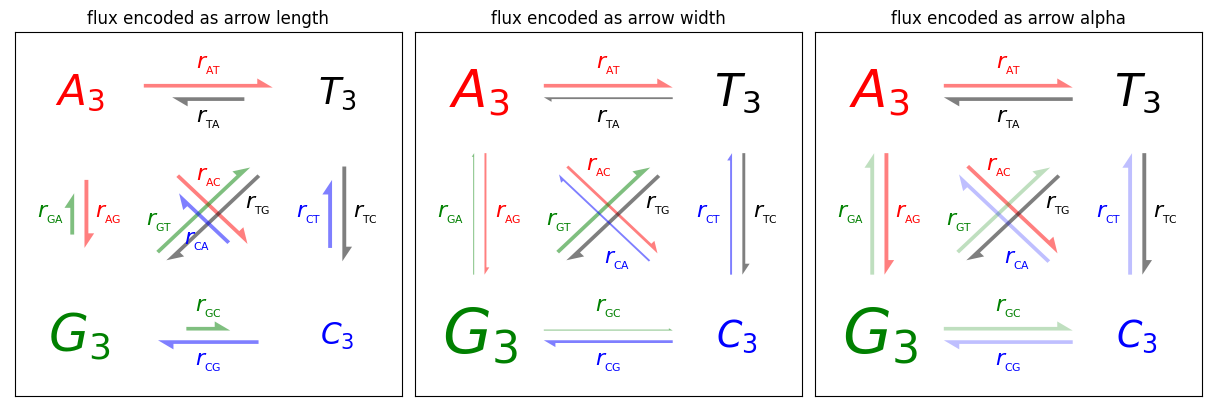

In [3]:
if __name__ == "__main__":
    data = {
        "A": 0.4, "T": 0.3, "G": 0.6, "C": 0.2,
        "AT": 0.4, "AC": 0.3, "AG": 0.2,
        "TA": 0.2, "TC": 0.3, "TG": 0.4,
        "CT": 0.2, "CG": 0.3, "CA": 0.2,
        "GA": 0.1, "GT": 0.4, "GC": 0.1,
    }
    
    size = 4
    fig = plt.figure(figsize=(3 * size, size), constrained_layout=True)
    axs = fig.subplot_mosaic([["length", "width", "alpha"]])
    
    for display, ax in axs.items():
        make_arrow_graph(
            ax, data, display=display, linewidth=0.001,
            edgecolor=None, normalize_data=True, size=size,
        )

plt.show()